In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import spacy
from torchtext.legacy.data import Field, TabularDataset, BucketIterator
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
!python -m spacy download en

     |████████████████████████████████| 37.4 MB 9.6 MB/s             
  Preparing metadata (setup.py) ... - done

    Linking successful
    /home/agent006/Downloads/fcn-pytorch/venv/lib/python3.6/site-packages/en_core_web_sm
    -->
    /home/agent006/Downloads/fcn-pytorch/venv/lib/python3.6/site-packages/spacy/data/en

    You can now load the model via spacy.load('en')



## Tokenizer

In [3]:
spacy_eng = spacy.load("en_core_web_sm")
def tokenize_eng(text):
    return [tok.text for tok in spacy_eng.tokenizer(text)]

## Split Dataset into Train and Test splits

In [4]:
from numpy.random import RandomState

df = pd.read_csv('lyric.csv')
df['artist'] = df['artist'].astype('category')
idx_to_cat = dict(enumerate(df['artist'].cat.categories))
cat_columns = df.select_dtypes(['category']).columns
df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)

rng = RandomState()
tr = df.sample(frac=0.7, random_state=rng)
tst = df.loc[~df.index.isin(tr.index)]
tr.to_csv('train.csv', index=False)
tst.to_csv('valid.csv', index=False)

# Train and Test iterators

In [5]:
lyric = Field(sequential=True, use_vocab=True, tokenize=tokenize_eng, lower=True, init_token="<sos>", eos_token="<eos>")
artist = Field(sequential=False, use_vocab=False)

fields = {"text": ("lyric", lyric), "artist": ("artist", artist)}

train_data, test_data = TabularDataset.splits(
    path="./",
    train="train.csv", test="valid.csv",
    format="csv", fields=fields
)

lyric.build_vocab(train_data, max_size=10000, min_freq=2)

In [6]:
device = torch.device("cpu")
batch_size = 8

train_iterator, test_iterator = BucketIterator.splits(
    (train_data, test_data), batch_size=batch_size, device=device, sort=False
)

## Transformer Model

In [7]:
class Transformer(nn.Module):
    def __init__(
        self,
        embedding_size,
        src_vocab_size,
        num_heads,
        num_encoder_layers,
        forward_dim,
        dropout,
        max_len,
        num_classes,
        device,
    ):
        super(Transformer, self).__init__()
        
        self.embedding = nn.Embedding(src_vocab_size, embedding_size).to(device)
        self.pos_embedding = nn.Embedding(max_len+1, embedding_size).to(device)
        
        cls_token_weights = torch.randn(1, 1, embedding_size).to(device)
        self.cls_token = nn.Parameter(cls_token_weights).to(device)
        
        self.device = device
        self.transformer_enc_layer = nn.TransformerEncoderLayer(embedding_size, num_heads, forward_dim, dropout).to(device)
        self.transformer_enc = nn.TransformerEncoder(self.transformer_enc_layer, num_encoder_layers).to(device)

        self.fc_clf = nn.Sequential(
            nn.Linear(embedding_size, embedding_size),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(embedding_size, embedding_size),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(embedding_size, num_classes),
        ).to(device)
        
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        seq_length, N = src.shape
        
        src_positions = torch.arange(0, seq_length+1).unsqueeze(1).expand(seq_length+1, N).to(self.device)
        
        embed = self.embedding(src).to(self.device)
        cls_token_batch = self.cls_token.repeat(1, N, 1).to(self.device)
        embed = torch.cat((cls_token_batch, embed), 0).to(self.device)
        embed_src = self.dropout(embed + self.pos_embedding(src_positions)).to(self.device)
        
        out = self.transformer_enc(embed_src).to(self.device)
        cls_tokens = out[0, :, :].to(self.device)
        out = self.fc_clf(cls_tokens).to(self.device)
        return out

## Function for computing F1

In [8]:
def f1_score_from_prob(class_probs, labels, from_gpu=True):
    if from_gpu:
        class_probs = class_probs.cpu().detach().numpy()
        labels = labels.cpu().detach().numpy()
    preds = class_probs.argmax(1)
    return f1_score(labels, preds, average='macro')

## Train step function (single epoch)

In [9]:
def train_step(model, loss, optim, scheduler, train_iterator, device):
    cumm_epoch_loss = 0
    cumm_epoch_f1 = 0
        
    for data_pair in tqdm(train_iterator):
        lyric = data_pair.lyric.to(device)
        artist = data_pair.artist.to(device)
            
        optim.zero_grad()
            
        pred = model(lyric).to(device)
        batch_loss = loss(pred, artist).to(device)
        batch_loss.backward()
        optim.step()
            
            
        cumm_epoch_loss += batch_loss
        cumm_epoch_f1 += f1_score_from_prob(pred, artist, from_gpu=True)
    
    if scheduler is not None:
        scheduler.step()
        
    epoch_loss = cumm_epoch_loss/len(train_iterator)
    epoch_f1 = cumm_epoch_f1/len(train_iterator)
    
    return epoch_loss, epoch_f1

## Validation Function

In [10]:
def validate(model, loss, test_iterator, device):
    model.eval()
    with torch.no_grad():
        cumm_loss = 0
        cumm_f1 = 0
        
        for data_pair in test_iterator:
            lyric = data_pair.lyric.to(device)
            artist = data_pair.artist.to(device)
            
            pred = model(lyric).to(device)
            batch_loss = loss(pred, artist).to(device)
            
            cumm_loss += batch_loss
            cumm_f1 += f1_score_from_prob(pred, artist, from_gpu=True)
    
    test_loss = cumm_loss/len(test_iterator)
    test_f1 = cumm_f1/len(test_iterator)
    return test_loss, test_f1

## Define Model

In [11]:
model = Transformer(embedding_size=64,
        src_vocab_size=10000,
        num_heads=4,
        num_encoder_layers=6,
        forward_dim=64,
        dropout=0.5,
        max_len=1600,
        num_classes=41,
        device=device)

## Training

In [12]:
verbose = False

optim = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=8e-4) 
scheduler = None
loss = nn.CrossEntropyLoss()
    
train_losses = []
train_f1s = []
    
test_losses = []
test_f1s = []

epochs = 20 
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    model.train()
    epoch_loss, epoch_f1 = train_step(model, loss, optim, scheduler, train_iterator, device)
    test_loss, test_f1 = validate(model, loss, test_iterator, device)
        
    train_losses.append(epoch_loss.cpu().detach().numpy())
    train_f1s.append(epoch_f1)
    test_losses.append(test_loss.cpu().detach().numpy())
    test_f1s.append(test_f1)
        
    if verbose:
        print(f'Train Loss: {epoch_loss}')
        print(f'Train F1 Score: {epoch_f1}')
        print(f'Test Loss: {test_loss}')
        print(f'Test F1 Score: {test_f1}')


Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


100%|██████████| 313/313 [02:29<00:00,  2.10it/s]


## Train and Test Loss + Metrics

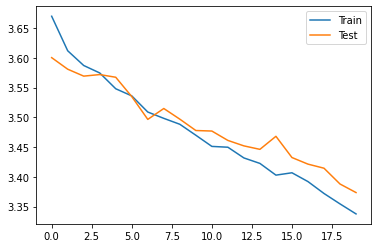

In [13]:
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.legend()

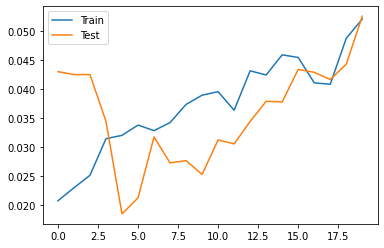

In [14]:
plt.plot(train_f1s, label='Train')
plt.plot(test_f1s, label='Test')
plt.legend()

In [17]:
def get_preds_targets(data_iterator, model, device):
    preds = torch.Tensor().to(device)
    targets = torch.Tensor().to(device)
    
    with torch.no_grad():
        for data_pair in data_iterator:
            lyric = data_pair.lyric.to(device)
            target = data_pair.artist.to(device)
            pred = model(lyric).to(device)
            
            preds = torch.cat((preds, pred), 0)
            targets = torch.cat((targets, target), 0)
    
    preds = preds.argmax(1)
    preds = preds.cpu().detach().numpy()
    targets = targets.cpu().detach().numpy()
    
    return preds, targets
    
train_preds, train_targets = get_preds_targets(train_iterator, model, device)
test_preds, test_targets = get_preds_targets(test_iterator, model, device)

In [18]:
test_loss, test_f1 = validate(model, loss, test_iterator, device)
train_loss, train_f1 = validate(model, loss, train_iterator, device)
train_acc, test_acc = accuracy_score(train_targets, train_preds), accuracy_score(test_targets, test_preds)

print(f"Train Loss: {train_loss}")
print(f"Train F1 Score: {train_f1}")
print(f"Train Acc: {train_acc}")
print(f"Test Loss: {test_loss}")
print(f"Test F1 Score: {test_f1}")
print(f"Test Acc: {test_acc}")

Train Loss: 3.2704055309295654
Train F1 Score: 0.05094567471678378
Train Acc: 0.10528422738190553
Test Loss: 3.3735909461975098
Test F1 Score: 0.052619909802745626
Test Acc: 0.1


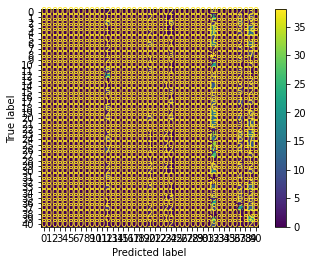

In [19]:
cm = confusion_matrix(test_targets, test_preds)
cm_display = ConfusionMatrixDisplay(cm)
cm_display.plot()